In [1]:
from typing import Dict, Tuple
from tqdm.auto import trange, tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image, make_grid

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, input_channels: int, output_channels: int, use_residual: bool = False) -> None:
        super().__init__()
        self.match_channels = input_channels == output_channels
        self.use_residual = use_residual
        self.first_conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 1, 1),
            nn.BatchNorm2d(output_channels),
            nn.GELU(),
        )
        self.second_conv = nn.Sequential(
            nn.Conv2d(output_channels, output_channels, 3, 1, 1),
            nn.BatchNorm2d(output_channels),
            nn.GELU(),
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        if self.use_residual:
            conv1_output = self.first_conv(input_tensor)
            conv2_output = self.second_conv(conv1_output)
            if self.match_channels:
                output = input_tensor + conv2_output
            else:
                output = conv1_output + conv2_output
            return output / 1.414
        else:
            conv1_output = self.first_conv(input_tensor)
            return self.second_conv(conv1_output)


class DownBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        modules = [ConvBlock(input_channels, output_channels), nn.MaxPool2d(2)]
        self.sequence = nn.Sequential(*modules)

    def forward(self, input_tensor):
        return self.sequence(input_tensor)


class UpBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        modules = [
            nn.ConvTranspose2d(input_channels, output_channels, 2, 2),
            ConvBlock(output_channels, output_channels),
            ConvBlock(output_channels, output_channels),
        ]
        self.sequence = nn.Sequential(*modules)

    def forward(self, input_tensor, concatenated_tensor):
        combined_tensor = torch.cat((input_tensor, concatenated_tensor), 1)
        return self.sequence(combined_tensor)


class FCBlock(nn.Module):
    def __init__(self, input_dimension, embedding_dimension):
        super().__init__()
        self.input_dimension = input_dimension
        modules = [
            nn.Linear(input_dimension, embedding_dimension),
            nn.GELU(),
            nn.Linear(embedding_dimension, embedding_dimension),
        ]
        self.sequence = nn.Sequential(*modules)

    def forward(self, input_tensor):
        reshaped_tensor = input_tensor.view(-1, self.input_dimension)
        return self.sequence(reshaped_tensor)


class EnhancedUnet(nn.Module):
    def __init__(self, input_channels, feature_dim = 256, num_classes=10):
        super().__init__()
        self.input_channels = input_channels
        self.feature_dim = feature_dim
        self.num_classes = num_classes

        self.initial_conv = ConvBlock(input_channels, feature_dim, use_residual=True)

        self.down_block1 = DownBlock(feature_dim, feature_dim)
        self.down_block2 = DownBlock(feature_dim, 2 * feature_dim)

        self.flatten = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.temporal_embedding1 = FCBlock(1, 2*feature_dim)
        self.temporal_embedding2 = FCBlock(1, feature_dim)
        self.context_embedding1 = FCBlock(num_classes, 2*feature_dim)
        self.context_embedding2 = FCBlock(num_classes, feature_dim)

        self.up_sample = nn.Sequential(
            nn.ConvTranspose2d(2 * feature_dim, 2 * feature_dim, kernel_size=16, stride=8, padding=4),
            nn.GroupNorm(8, 2 * feature_dim),
            nn.ReLU(),
        )

        self.up_block1 = UpBlock(4 * feature_dim, feature_dim)
        self.up_block2 = UpBlock(2 * feature_dim, feature_dim)
        self.final_conv = nn.Sequential(
            nn.Conv2d(2 * feature_dim, feature_dim, 3, 1, 1),
            nn.GroupNorm(8, feature_dim),
            nn.ReLU(),
            nn.Conv2d(feature_dim, self.input_channels, 3, 1, 1),
        )

    def forward(self, input_tensor, context, time_step, mask):
        processed_tensor = self.initial_conv(input_tensor)
        down1_output = self.down_block1(processed_tensor)
        down2_output = self.down_block2(down1_output)
        hidden_vector = self.flatten(down2_output)

        context_onehot = nn.functional.one_hot(context, num_classes=self.num_classes).type(torch.float)
        masked_context = mask[:, None].repeat(1, self.num_classes)
        masked_context = (-1 * (1 - masked_context))
        masked_context = context_onehot * masked_context

        context_emb1 = self.context_embedding1(masked_context).view(-1, self.feature_dim * 2, 1, 1)
        time_emb1 = self.temporal_embedding1(time_step).view(-1, self.feature_dim * 2, 1, 1)
        context_emb2 = self.context_embedding2(masked_context).view(-1, self.feature_dim, 1, 1)
        time_emb2 = self.temporal_embedding2(time_step).view(-1, self.feature_dim, 1, 1)

        up1_output = self.up_sample(hidden_vector)
        up2_output = self.up_block1(context_emb1 * up1_output + time_emb1, down2_output)
        final_output = self.up_block2(context_emb2 * up2_output + time_emb2, down1_output)
        return self.final_conv(torch.cat((final_output, processed_tensor), 1))


def schedule_ddpm(beta_start, beta_end, total_steps):
    beta_range = (beta_end - beta_start) * torch.arange(0, total_steps + 1, dtype=torch.float32) / total_steps + beta_start
    sqrt_beta = torch.sqrt(beta_range)
    alpha = 1 - beta_range
    log_alpha = torch.log(alpha)
    cumulative_alpha = torch.cumsum(log_alpha, dim=0).exp()

    sqrt_cum_alpha = torch.sqrt(cumulative_alpha)
    one_over_sqrt_alpha = 1 / torch.sqrt(alpha)

    sqrt_one_minus_cum_alpha = torch.sqrt(1 - cumulative_alpha)
    one_minus_alpha_over_sqrt_one_minus_cum_alpha = (1 - alpha) / sqrt_one_minus_cum_alpha

    return {
        "alpha": alpha,
        "one_over_sqrt_alpha": one_over_sqrt_alpha,
        "sqrt_beta": sqrt_beta,
        "cumulative_alpha": cumulative_alpha,
        "sqrt_cum_alpha": sqrt_cum_alpha,
        "sqrt_one_minus_cum_alpha": sqrt_one_minus_cum_alpha,
        "one_minus_alpha_over_sqrt_one_minus_cum_alpha": one_minus_alpha_over_sqrt_one_minus_cum_alpha,
    }


class DiffusionModel(nn.Module):
    def __init__(self, model, betas, num_steps, device, dropout_probability=0.1):
        super().__init__()
        self.model = model.to(device)
        for key, value in schedule_ddpm(betas[0], betas[1], num_steps).items():
            self.register_buffer(key, value)

        self.num_steps = num_steps
        self.device = device
        self.dropout_probability = dropout_probability
        self.mse_loss = nn.MSELoss()

    def forward(self, input_tensor, context):
        time_indices = torch.randint(1, self.num_steps+1, (input_tensor.shape[0],)).to(self.device)
        random_noise = torch.randn_like(input_tensor)

        processed_tensor = (
            self.sqrt_cum_alpha[time_indices, None, None, None] * input_tensor
            + self.sqrt_one_minus_cum_alpha[time_indices, None, None, None] * random_noise
        )
        context_dropout = torch.bernoulli(torch.zeros_like(context)+self.dropout_probability).to(self.device)
        return self.mse_loss(random_noise, self.model(processed_tensor, context, time_indices / self.num_steps, context_dropout))

    def sample(self, sample_count, dimensions, device, guidance_weight = 0.0):
        initial_noise = torch.randn(sample_count, *dimensions).to(device)
        context_indices = torch.arange(0, self.model.num_classes).to(device)
        context_indices = context_indices.repeat(int(sample_count / context_indices.shape[0]))

        context_mask = torch.zeros_like(context_indices).to(device)

        context_indices = context_indices.repeat(2)
        context_mask = context_mask.repeat(2)
        context_mask[sample_count:] = 1.0

        stored_samples = []
        for time_step in range(self.num_steps, 0, -1):
            print(f'Sampling timestep {time_step}',end='\r')
            time_tensor = torch.tensor([time_step / self.num_steps]).to(device)
            time_tensor = time_tensor.repeat(sample_count, 1, 1, 1)

            initial_noise = initial_noise.repeat(2, 1, 1, 1)
            time_tensor = time_tensor.repeat(2, 1, 1, 1)

            additional_noise = torch.randn(sample_count, *dimensions).to(device) if time_step > 1 else 0

            predicted_noise = self.model(initial_noise, context_indices, time_tensor, context_mask)
            predicted_noise1 = predicted_noise[:sample_count]
            predicted_noise2 = predicted_noise[sample_count:]
            predicted_noise = (1 + guidance_weight) * predicted_noise1 - guidance_weight * predicted_noise2
            initial_noise = initial_noise[:sample_count]
            initial_noise = (
                self.one_over_sqrt_alpha[time_step] * (initial_noise - predicted_noise * self.one_minus_alpha_over_sqrt_one_minus_cum_alpha[time_step])
                + self.sqrt_beta[time_step] * additional_noise
            )
            if time_step % 20 == 0 or time_step == self.num_steps or time_step < 8:
                stored_samples.append(initial_noise.detach().cpu().numpy())

        stored_samples = np.array(stored_samples)
        return initial_noise, stored_samples


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

Saved image at ./outputs-v2/image_epoch0_w0.0.png
Saved image at ./outputs-v2/gif_epoch0_w0.0.gif
Saved image at ./outputs-v2/image_epoch0_w0.5.png
Saved image at ./outputs-v2/gif_epoch0_w0.5.gif
Saved image at ./outputs-v2/image_epoch0_w2.0.png


KeyboardInterrupt: 

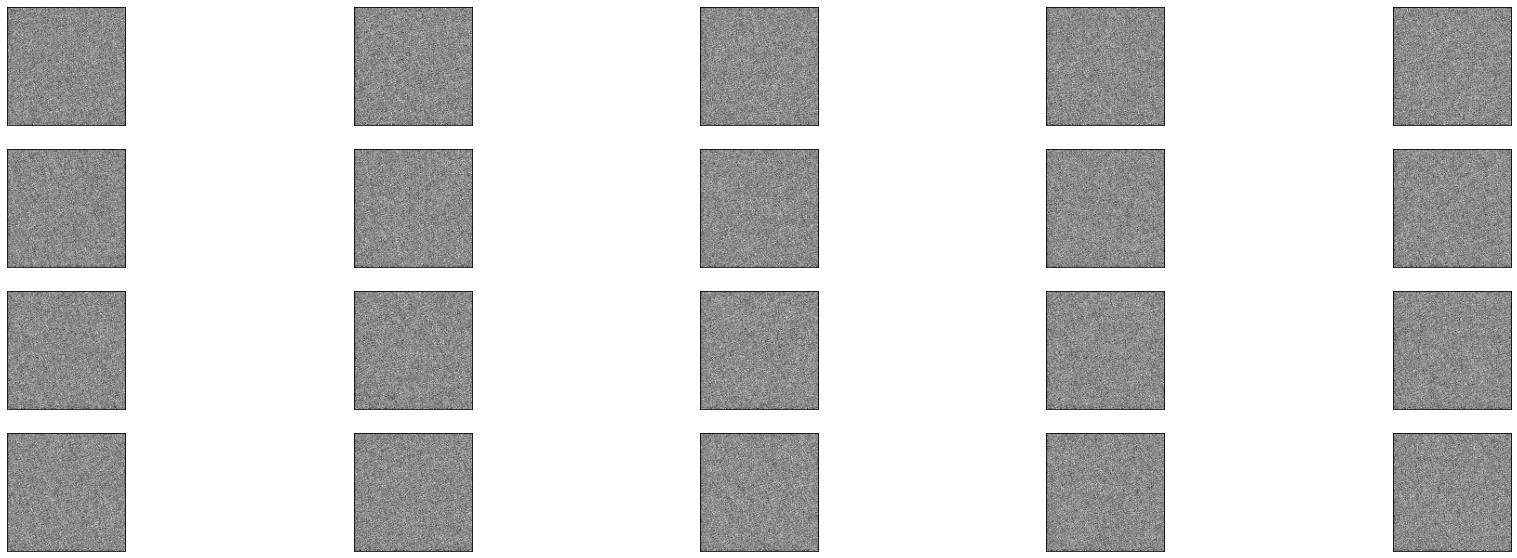

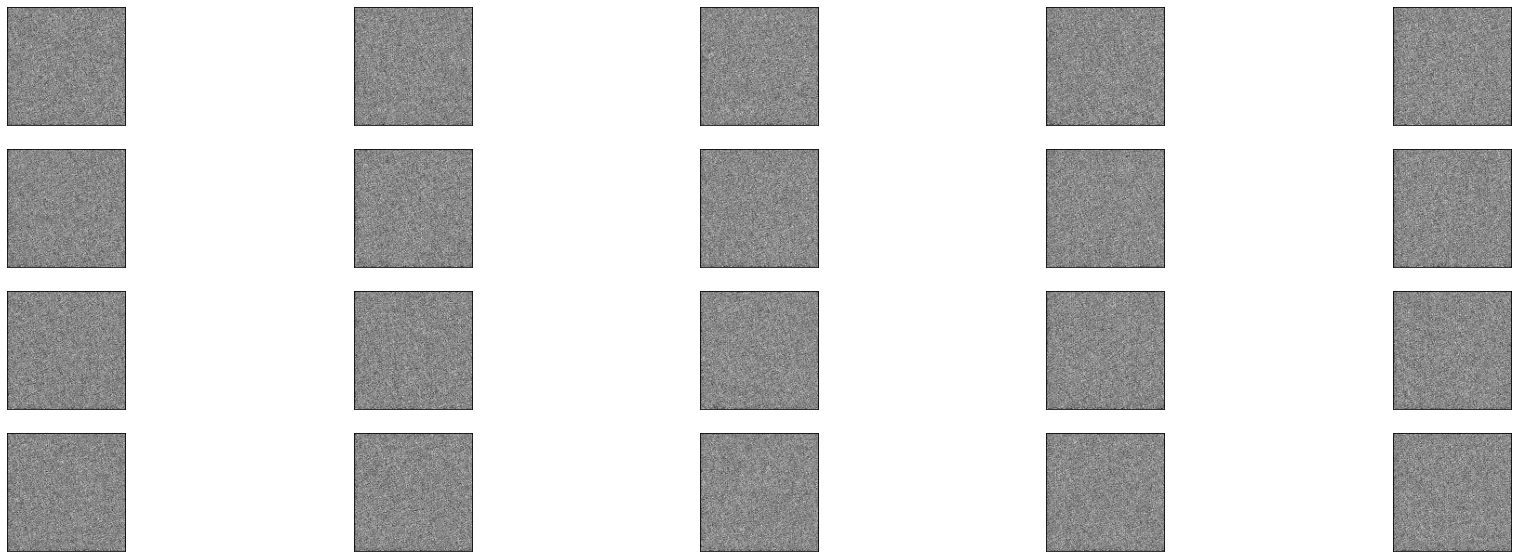

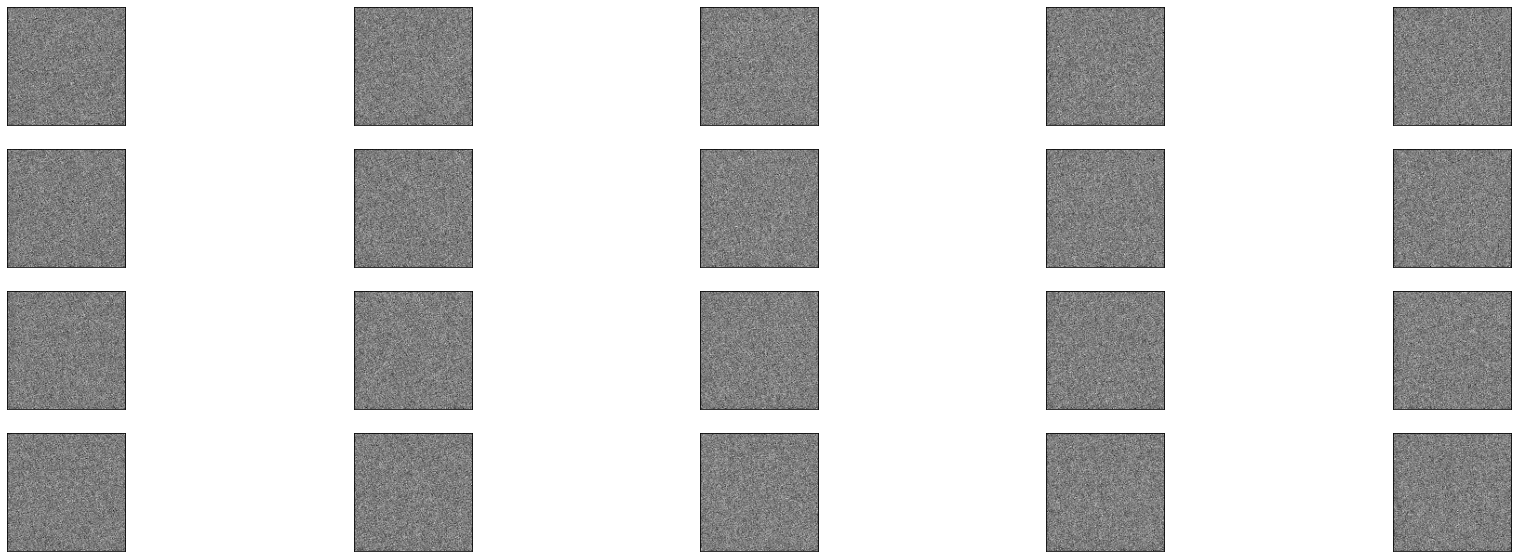

In [6]:
from tqdm.auto import tqdm, trange
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import torch.optim as optim
import torch

# Configuration and Setup
epochs = 500
batch_size = 32
steps = 500
device_setting = "cuda:2"
classes = 5
features = 256
rate = 6e-5
save_check = True
output_path = './outputs-v2/'
weights = [0.0, 0.5, 2.0]
eval_every = 20

# Model Initialization
model = DiffusionModel(
    model=EnhancedUnet(input_channels=3, feature_dim=features, num_classes=classes),
    betas=[1e-4, 0.02], num_steps=steps, device=device_setting, dropout_probability=0.1)
model.to(device_setting)

# Data Loading
path = "transient-attr-images/train"
adjustment = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
data = ImageFolder(root=path, transform=adjustment)
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0)

# Optimizer
opt = optim.Adam(model.parameters(), lr=rate)

# Training
for epoch in trange(epochs, desc="Epoch"):
    model.train()
    opt.param_groups[0]['lr'] = rate * (1 - epoch / epochs)
    progress = tqdm(loader)
    current_loss = None

    for imgs, labels in progress:
        opt.zero_grad()
        imgs = imgs.to(device_setting)
        labels = labels.to(device_setting)
        loss = model(imgs, labels)
        loss.backward()
        opt.step()

        if current_loss is None:
            current_loss = loss.item()
        else:
            current_loss = 0.95 * current_loss + 0.05 * loss.item()
        progress.set_description(f"Loss: {current_loss:.4f}")

    if epoch % eval_every == 0:
        model.eval()
        with torch.no_grad():
            sample_count = 4 * classes
            for weight_index, weight in enumerate(weights):
                generated, stored_samples = model.sample(sample_count, (3, 128, 128), device_setting, weight)
                real_imgs = torch.Tensor(generated.shape).to(device_setting)
                
                for class_index in range(classes):
                    for sample_index in range(sample_count // classes):
                        try:
                            index = torch.squeeze((labels == class_index).nonzero(as_tuple=False)[sample_index])
                        except:
                            index = 0
                        real_imgs[class_index + (sample_index * classes)] = imgs[index]

                combined = torch.cat([generated, real_imgs])
                grid = make_grid(combined * -1 + 1, nrow=10)
                save_image(grid, f"{output_path}image_epoch{epoch}_w{weight}.png")
                print(f'Saved image at {output_path}image_epoch{epoch}_w{weight}.png')
                
                if epoch % 50 == 0 or ep == int(n_epoch-1):
                    fig, axs = plt.subplots(nrows=int(sample_count/classes), ncols=classes,sharex=True,sharey=True,figsize=(30,10))
                    def animate_diff(i, x_gen_store):
                        print(f'gif animating frame {i} of {x_gen_store.shape[0]}', end='\r')
                        plots = []
                        for row in range(int(sample_count/classes)):
                            for col in range(classes):
                                axs[row, col].clear()
                                axs[row, col].set_xticks([])
                                axs[row, col].set_yticks([])
                                # plots.append(axs[row, col].imshow(x_gen_store[i,(row*n_classes)+col,0],cmap='gray'))
                                plots.append(axs[row, col].imshow(-x_gen_store[i,(row*classes)+col,0],cmap='gray',vmin=(-x_gen_store[i]).min(), vmax=(-x_gen_store[i]).max()))
                        return plots
                    ani = FuncAnimation(fig, animate_diff, fargs=[stored_samples],  interval=200, blit=False, repeat=True, frames=stored_samples.shape[0])    
                    ani.save(f"{output_path}gif_epoch{epoch}_w{weight}.gif", dpi=100, writer=PillowWriter(fps=5))
                    print(f"Saved image at {output_path}gif_epoch{epoch}_w{weight}.gif")

    if save_check and epoch == epochs - 1:
        torch.save(model.state_dict(), f"{output_path}model_epoch{epoch}.pth")
        print(f'Model saved at {output_path}model_epoch{epoch}.pth')


In [ ]:
!nvidia-smi

In [ ]:
torch.save(model.state_dict(), "model-latest.pth")